In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse, r2_score

os.chdir("..")

In [2]:
df_pXhat_X = pd.read_pickle("data/df_pXhat_X.pkl")
df_pY_Xhat = pd.read_pickle("data/df_pY_Xhat.pkl")
df_surprise = pd.read_pickle("data/df_surprise.pkl")

In [3]:
Ns = df_surprise.index
betas = df_surprise.columns

# Load Simulation

In [4]:
d_S = {}
path = os.path.join("data","surprise_signal_from_simulated_block")
fnames = [os.path.join(path, f) for f in os.listdir(path)]
for i, name in enumerate(fnames):
    # infer key from fname
    k = tuple(float(p) for p in os.path.splitext(name.split("\\")[-1])[0].split("_"))
    if (i+1)%500==0:
        print(i+1)
    d_S[k] = pd.read_pickle(name)

500
1000
1500
2000
2500


# Alternative Model: Linear Regression
AUC = xt*MA*w1 + (1-xt)*(MA)*w2 + xt + Const \
MA is Exponential Moving Average (depend on hyperparameter alpha) \
Regressoin will be fitted by a regularized loss (Ridge), depended on hyperparameter lambda

In [5]:
def simulate_auc(S, sigma):
    auc = S + np.random.normal(scale=sigma, size=len(S))
    if isinstance(auc, pd.Series):
        return auc.rename("AUC")
    return auc

# AUC = xt*MA*w1 + (1-xt)*(MA)*w2 + xt + Const
def preprocess_reg(df_model, ma_alpha=.1):
    df_model["MA(t-1)"] = df_model["block"].ewm(alpha=ma_alpha).mean().shift(1)
    df_model = df_model.dropna() # shift caused dropping a value
    out_cols = {}
    out_cols['x1'] = df_model["block"] * df_model["MA(t-1)"]
    out_cols['x2'] = (1-df_model["block"]) * df_model["MA(t-1)"]
    out_cols['x3'] = df_model["block"]
    features = pd.DataFrame.from_dict(out_cols)
    return pd.concat([df_model, features], axis=1)

def split_block(data):    
    train, test = train_test_split(data, test_size=.2, random_state=123)
    train = train.sort_index()
    test = test.sort_index()
    return train, test

def ridge_with_ma(train, test, feature_cols, label_col="AUC", reg_lambda=1):
    reg = Ridge(alpha=reg_lambda, random_state=123)
    reg.fit(train[feature_cols], train[label_col])
    return reg

## MA conditioned on Oddball Against AUC
pre-analysis in order to define a linear model. This model features ("variables" or "X's") will be based on MA of t-1 trials and the current trial values.

In [6]:
N = 15
BETA = betas[11]
print(f"N:{N}", f"BETA:{BETA}")

df_model = d_S[(N, BETA)]
df_model["AUC"] = simulate_auc(df_model["S"], sigma=0.0)
# df_model["AUC"] = df_model["S"]
df_model = df_model[["block","AUC"]].dropna()
df_model

N:15 BETA:35.564803062231285


,block,AUC
15,0,0.411974
16,0,0.286554
17,0,0.286554
18,0,0.169033
19,0,0.169033
...,...,...
1195,0,0.957260
1196,0,0.806458
1197,0,0.667300
1198,1,1.767293


In [7]:
df_model["MA(t-1)"] = df_model["block"].ewm(alpha=.1).mean().shift(1)

xlabels are MA(t-1) ranged between 0-1


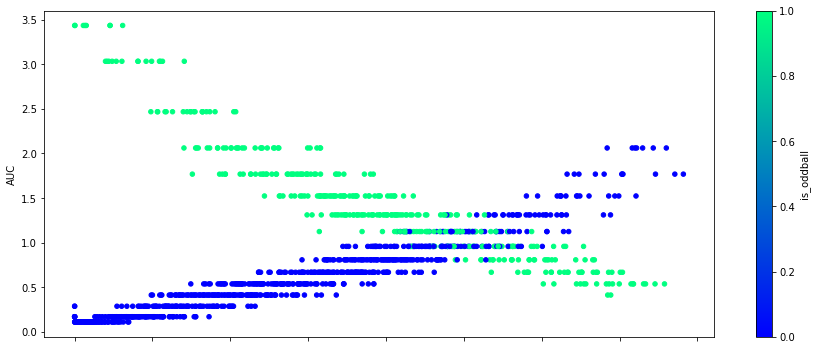

In [8]:
df_model.rename(columns={"block":"is_oddball"}).plot(
    kind="scatter", x="MA(t-1)", y="AUC", figsize=(15,6), c="is_oddball", cmap="winter");
print("xlabels are MA(t-1) ranged between 0-1")

# Apply Model to different Hyperparameters (alpha and lambda)

In [9]:
N = 15
BETA = betas[11]
print(f"N:{N}", f"BETA:{BETA}")

df_model = d_S[(N, BETA)]
df_model["AUC"] = simulate_auc(df_model["S"], sigma=0.0)
df_model = df_model[["block","AUC"]].dropna()

N:15 BETA:35.564803062231285


In [10]:
data_with_features = preprocess_reg(df_model, ma_alpha=0.1)
train, test = split_block(data_with_features)
d_lambda = {}
feature_cols=['x1','x2','x3']

## Tune Lambda (Regularization) and Fix Alpha (MA)

In [11]:
lambdas = np.linspace(0,5, num=100)
for l in range(len(lambdas)):
    d_lambda[l] = {}
    reg = ridge_with_ma(train, test,feature_cols=feature_cols, reg_lambda=lambdas[l])
    train_preds = reg.predict(train[feature_cols])
    test_preds = reg.predict(test[feature_cols])
    
    d_lambda[l]["lambda"] = lambdas[l]
    d_lambda[l]["reg"] = reg
    d_lambda[l]["r2"] = r2_score(train["AUC"], train_preds)
    d_lambda[l]["train_mse"] = mse(train["AUC"], train_preds)
    d_lambda[l]["test_mse"] = mse(test["AUC"], test_preds)

df_res = pd.DataFrame.from_dict(d_lambda).T
reg_obj_col = df_res['reg'].values
df_res = df_res.drop(columns="reg").astype(float)
df_res['reg'] = reg_obj_col

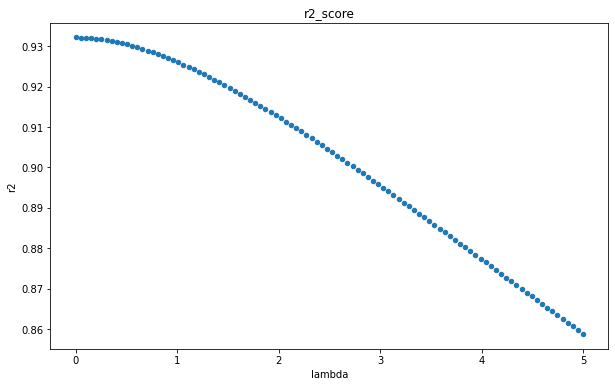

In [12]:
df_res.plot(kind="scatter", x="lambda", y="r2", title="r2_score", figsize=(10,6))
plt.show()

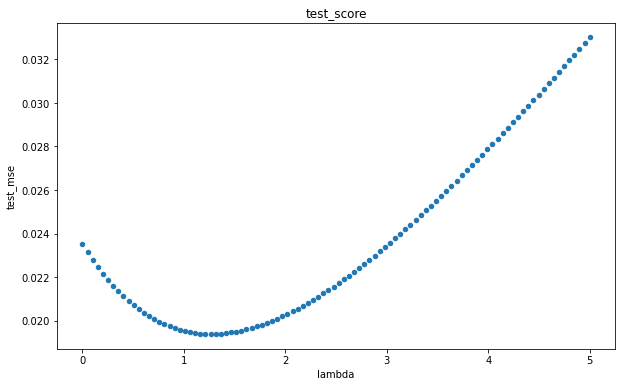

In [13]:
df_res.plot(kind="scatter", x="lambda", y="test_mse", title="test_score", figsize=(10,6))
plt.show()

### Choose Best Lambda and See fit

In [14]:
best_lambda, reg = df_res.loc[df_res['test_mse'].argmin(), ['lambda','reg']]

In [15]:
preds = reg.predict(data_with_features[feature_cols])

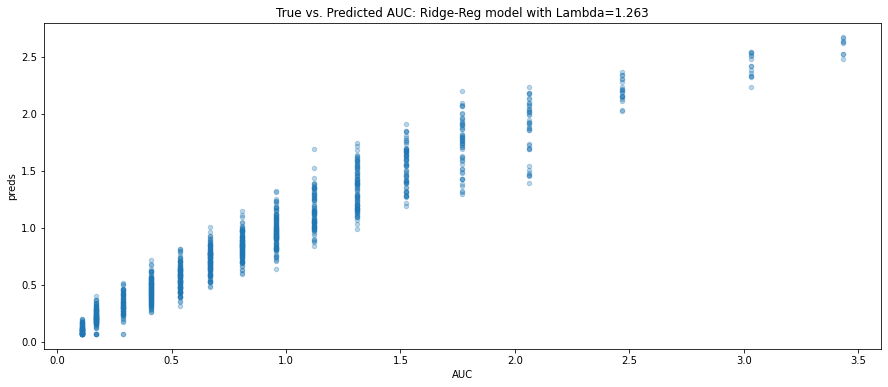

In [16]:
pd.concat([data_with_features['AUC'], pd.Series(preds, index=data_with_features.index, name="preds")], axis=1).plot(
    kind="scatter", x="AUC", y="preds", figsize=(15,6), alpha=.3)
plt.title(f"True vs. Predicted AUC: Ridge-Reg model with Lambda={np.round(best_lambda,3)}")
plt.show()

## Tune Alpha

In [17]:
N = 15
BETA = betas[11]
print(f"N:{N}", f"BETA:{BETA}")

df_model = d_S[(N, BETA)]
df_model["AUC"] = simulate_auc(df_model["S"], sigma=0.0)
df_model = df_model[["block","AUC"]].dropna()

N:15 BETA:35.564803062231285


In [18]:
alphas = np.linspace(1e-3, 1)
LAMBDA = 1.2
d_alpha = {}

for a in range(len(alphas)):
    d_alpha[a] = {}
    
    data_with_features = preprocess_reg(df_model, ma_alpha=alphas[a])
    train, test = split_block(data_with_features)
    feature_cols=['x1','x2','x3']
    reg = ridge_with_ma(train, test,feature_cols=feature_cols, reg_lambda=LAMBDA)
    
    train_preds = reg.predict(train[feature_cols])
    test_preds = reg.predict(test[feature_cols])
    
    d_alpha[a]["alpha"] = alphas[a]
    d_alpha[a]["reg"] = reg
    d_alpha[a]["r2"] = r2_score(train["AUC"], train_preds)
    d_alpha[a]["train_mse"] = mse(train["AUC"], train_preds)
    d_alpha[a]["test_mse"] = mse(test["AUC"], test_preds)

df_res = pd.DataFrame.from_dict(d_alpha).T
reg_obj_col = df_res['reg'].values
df_res = df_res.drop(columns="reg").astype(float)
df_res['reg'] = reg_obj_col

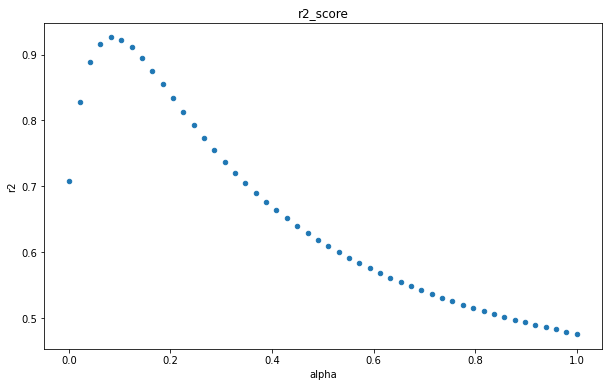

In [19]:
df_res.plot(kind="scatter", x="alpha", y="r2", title="r2_score", figsize=(10,6))
plt.show()

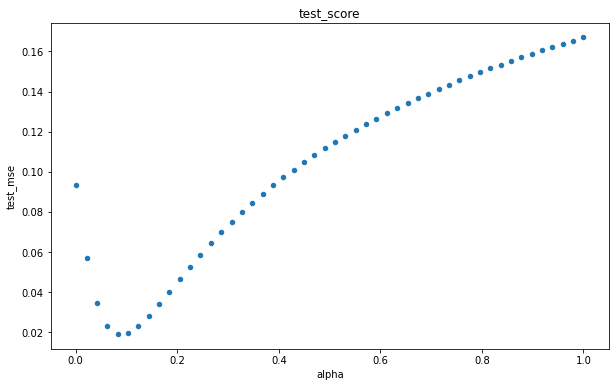

In [20]:
df_res.plot(kind="scatter", x="alpha", y="test_mse", title="test_score", figsize=(10,6))
plt.show()

### Choose Best Alpha and See fit

In [21]:
best_alpha, reg = df_res.loc[df_res['test_mse'].argmin(), ['alpha','reg']]

In [22]:
data_with_features = preprocess_reg(df_model, ma_alpha=best_alpha)
preds = reg.predict(data_with_features[feature_cols])

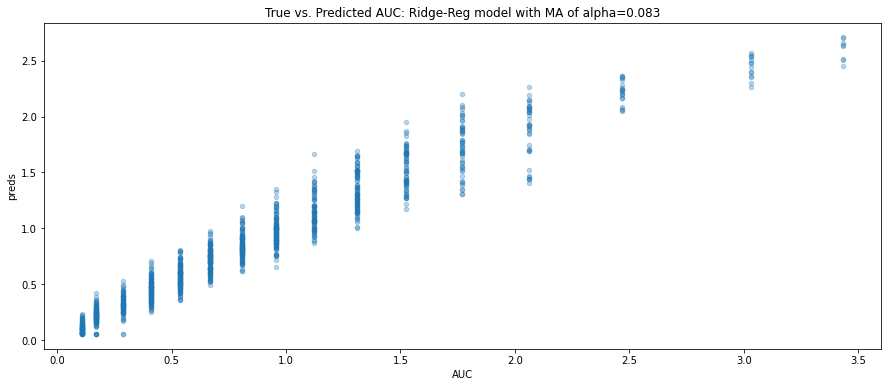

In [23]:
pd.concat([data_with_features['AUC'], pd.Series(preds, index=data_with_features.index, name="preds")], axis=1).plot(
    kind="scatter", x="AUC", y="preds", figsize=(15,6), alpha=.3)
plt.title(f"True vs. Predicted AUC: Ridge-Reg model with MA of alpha={np.round(best_alpha,3)}")
plt.show()